# Overnight returns

This notebook shows the striking divergence of overnight and intraday returns. This divergence is observed in equity indices in most of the major countries with a notable exception of China. Furtuermore, a significant portion of equity risk premium appears to be captures during overnight. And in fact, intraday returns appear to have *negative* risk premium. Possible expalanations are dicussed in [1].

In [1]:
%matplotlib inline
from datetime import datetime
import logging
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('bmh')

from vivace.backtest.contract import InstrumentDef
from vivace.backtest.engine import BacktestEngine
from vivace.backtest.enums import Strategy, PnLType

# Run backtest

A number of equity indices or ETFs are used for the backtest. Data for UK and China are missing in Yahoo Finance and omitted in this analysis. Following the methodology in [1], intraday and overnight returns are calculated as 
$$
r_{intraday, t} = \frac{Close_t}{Open_t} - 1, \\
r_{overnight, t} = \frac{ \frac{AdjClose_{t}}{AdjClose_{t-1}} }{ \frac{Close_t}{Open_t} } - 1.
$$

Furthermore some backtests start in later dates than inception dates because of the lack of open prices.

In [2]:
ticker_map = dict([
    ("SPY", dict(name="S&P 500 SPDR ETF", country="United States")),
    ("^IXIC", dict(name="NASDAQ Composite", country="United States", start_date=datetime(1984, 10, 10))),
    ("XIU.TO", dict(name="iShares TSX 60 ETF", country="Canada")),
    ("^FCHI", dict(name="CAC 40", country="France")),
    ("^GDAXI", dict(name="DAX", country="Germany", start_date=datetime(1993, 12, 13))),
    ("^AEX", dict(name="AEX", country="Netherlands")),
    ("OBXEDNB.OL", dict(name="DNB OBX ETF", country="Norway", start_date=datetime(2009, 11, 16))),
    ("^TA125.TA", dict(name="TA-125", country="Israel",
                       # more than half of the TA-125 overnight returns are zero before 2007.
                       start_date=datetime(2007, 1, 8))),
    ("STW.AX", dict(name="SPDR S&P/ASX 200 Fund", country="Australia")),
    ("^NSEI", dict(name="NIFTY 50", country="India")),
    ("^BSESN", dict(name="S&P BSE SENSEX", country="India")),
    ("^HSI", dict(name="Hang Seng Index", country="Hong Kong")),
    ("ES3.SI", dict(name="SPDR Straits Times Index ETF", country="Singapore")),
    ("^N225", dict(name="Nikkei 225", country="Japan", start_date=datetime(1988, 4, 7))),
    ("IMIB.MI", dict(name="iShares FTSE MIB ETF", country="Italy")),
    ("^KS11", dict(name="KOSPI Composite Index", country="Korea")),
    ("^TWII", dict(name="TSEC Weighted Index", country="Taiwan")),
    ("EWW", dict(name="iShares MSCI Mexico Capped ETF", country="Mexico")),
    ("EWZ", dict(name="iShares MSCI Brazil Capped ETF", country="Brazil")),
])

In [3]:
result = dict()

for key, value in ticker_map.items():
    common_params = {
        'strategy': Strategy.DELTA_ONE.value,
        'log_level': logging.WARNING,
    }
    if 'start_date' in value.keys():
        common_params['start_date'] = value['start_date']
    if 'end_date' in value.keys():
        common_params['end_date'] = value['end_date']
    
    overnight_engine = BacktestEngine(
        instrument=InstrumentDef(key, pnl_type=PnLType.CLOSE_TO_OPEN.value, rebalance_freq='d'),
        **common_params
    )
    intraday_engine = BacktestEngine(
        instrument=InstrumentDef(key, pnl_type=PnLType.OPEN_TO_CLOSE.value, rebalance_freq='d'),
        **common_params
    )
    overnight_engine.run()
    intraday_engine.run()
    
    overnight_equity = overnight_engine.calculate_equity_curve(calculate_net=False).rename('overnight')
    intraday_equity = intraday_engine.calculate_equity_curve(calculate_net=False).rename('intraday')
    result[f'{value["country"]} - {value["name"]}'] = pd.concat((overnight_equity, intraday_equity), axis=1)
    
#     break

In [4]:
# Get the union of indices for the plot to align the x-axis
plot_xaxis = pd.DatetimeIndex([])
for value in result.values():
    plot_xaxis = plot_xaxis.union(value.index)

## Since inception

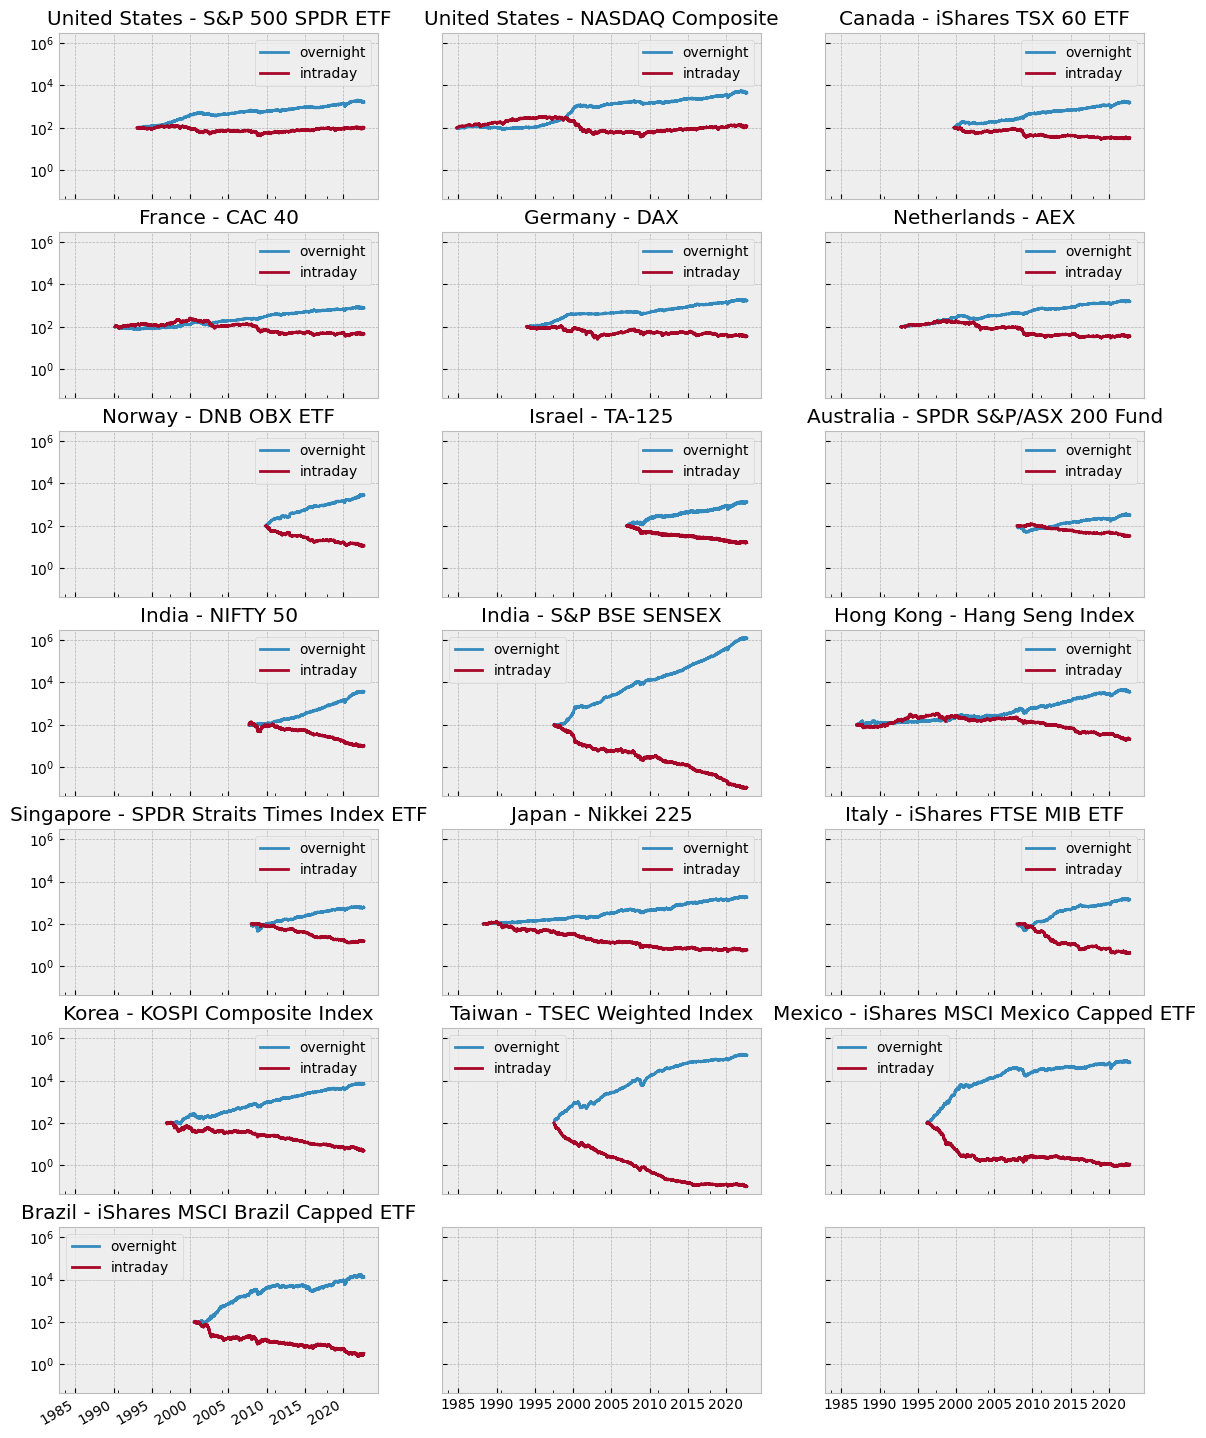

In [5]:
fig, axes = plt.subplots(7, 3, figsize=(14, 20), sharex=True, sharey=True)
axes = axes.flatten()

for idx, (key, value) in enumerate(result.items()):
    ax = axes[idx]
    value.reindex(index=plot_xaxis).plot(ax=ax, logy=True)
    ax.set_title(key)

## Recent performance

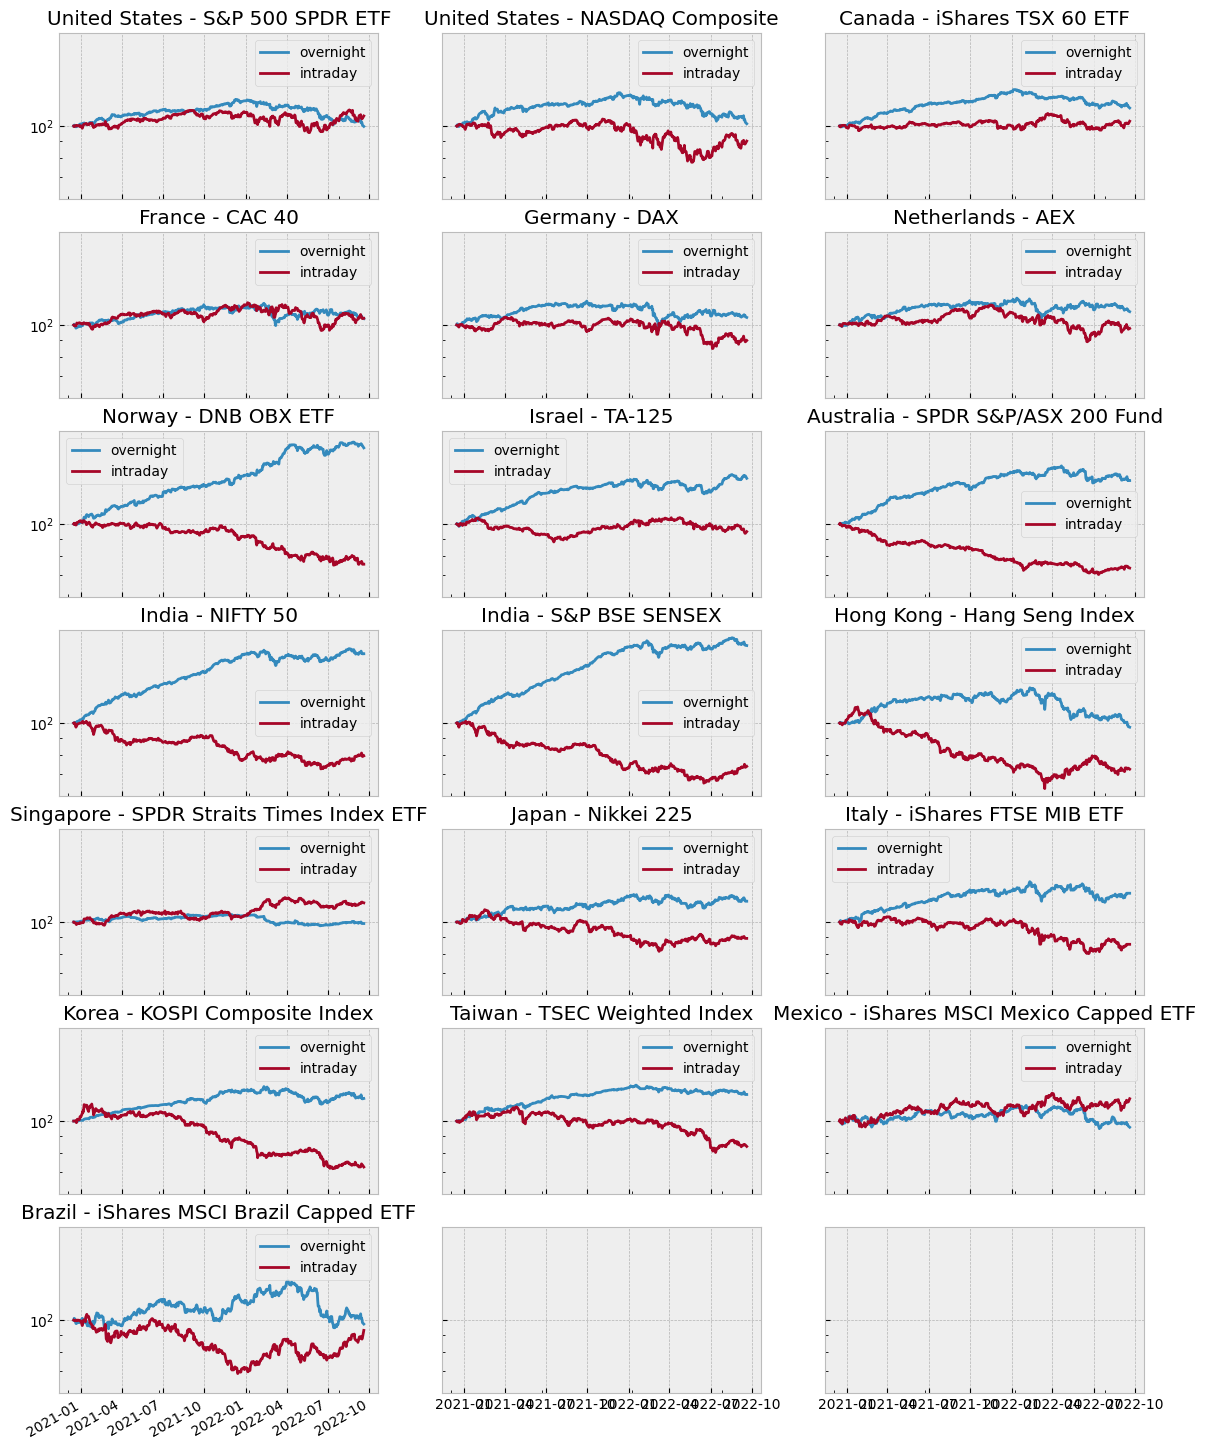

In [6]:
fig, axes = plt.subplots(7, 3, figsize=(14, 20), sharex=True, sharey=True)
axes = axes.flatten()

for idx, (key, value) in enumerate(result.items()):
    ax = axes[idx]
    (value.reindex(index=plot_xaxis).tail(252 * 2).pct_change().fillna(0).add(1).cumprod().mul(100)
     .plot(ax=ax, logy=True))
    ax.set_title(key)

# Reference
- Knuteson, B., 2020. Strikingly Suspicious Overnight and Intraday Returns. arXiv preprint arXiv:2010.01727.

In [7]:
print(f'Updated: {datetime.utcnow():%d-%b-%Y %H:%M}')

Updated: 20-Sep-2022 07:58
